In [1]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from dotenv import load_dotenv
import os
from langchain_nvidia_ai_endpoints import ChatNVIDIA

load_dotenv()
# We use the truncate="END" argument to ensure that the input not exceeds the maximum length.

embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5",api_key=os.getenv("NVIDIA_API_KEY"),truncate="END")
llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct",api_key=os.getenv("NVIDIA_API_KEY"),truncate="END")


## Self Querying

- **The idea**
  - As the name suggest, the retriever construct his own query from the User question.
  This query can countain filters.Of course we need an LLM for this conversion.
  - The New query  can countain or not Filters and it may countain a field for applying Sementic Search.
  
- **Why ?**
  - It's more optimal to use Sementic Search  inside a specific cluster than searching in the whole vector database.(specially if it's large)
  - In addition We enhance the relevance of retrieved chunks.
- **Important points**
  - To use this technique, the chunks must have attributes in their metadata, to use for filterig. 
  - The retriever here use an LLM.

In [ ]:
CHROMA_PATH = r"C:\Users\hp\Downloads\LLM_Courses\Pratiques\RAG\Self_Quering"

In [ ]:
from langchain_chroma import Chroma
from langchain_core.documents import Document

chunks = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]

vectorstore = Chroma.from_documents(chunks, embedder,persist_directory=CHROMA_PATH)

### Our Retriever

In [ ]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever


metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]
document_content_description = "Brief summary of a movie"

retriever1 = SelfQueryRetriever.from_llm(
    llm, vectorstore, 
    document_content_description, 
    metadata_field_info, 
    enable_limit=True
)

- Example 1

In [ ]:
UserQuery = "What are two movies about dinosaurs"
# The self-query generated by retriever
Selfquery = retriever1.query_constructor.invoke(UserQuery)
Selfquery

In [ ]:
retriever1.invoke(Selfquery)

- Example 2

In [ ]:
UserQuery = "What's a movie after 1990 but before 2005 that's all about toys, and preferably is animated"
# The self-query generated by retriever
Selfquery = retriever1.query_constructor.invoke(UserQuery)
Selfquery

In [ ]:
retriever1.invoke(Selfquery)

## VS as Retriever

In [ ]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(r"C:\Users\hp\Downloads\LLM_Courses\Pratiques\RAG\Advanced RAG\data\state_of_the_union.txt")

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter



documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5",api_key=os.getenv("NVIDIA_API_KEY"),truncate="END")

db = FAISS.from_documents(texts, embedder)

In [ ]:
retriever_similarity           = db.as_retriever(search_type = "similarity", search_kwargs = {"k": 2})
retriever_mmr                  = db.as_retriever(search_type = "mmr", search_kwargs = {"k": 2,"lambda_mult": 0.5})
retriever_similarity_threshold = db.as_retriever(search_type = "similarity_score_threshold", search_kwargs = {"score_threshold": 0.1})

In [ ]:
docs_similarity  = retriever_similarity.invoke("what did he say about ketanji brown jackson")
docs_similarity 

In [ ]:
docs_mmr  = retriever_mmr.invoke("what did he say about ketanji brown jackson")
docs_mmr

In [ ]:
docs_similarity_threshold  = retriever_similarity_threshold.invoke("what did he say about ketanji brown jackson")
print(docs_similarity_threshold)

## MultiQuery Retriever

- **The idea**
  - The Retriver generate multiple queries from the User one, for each query, it retrieves the relevant chunks from the vector database.
  
- **Why ?**
  - To get a richer set of results.
  
- **Important points**
  - The final result is a Union of all the unique retrieved chunks.
  - The retriever here use an LLM.

In [ ]:
# Build a sample vectorDB
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
path = r"C:\Users\hp\Downloads\LLM_Courses\Pratiques\RAG\Advanced RAG\database"
embedding = embedder
vectordb = Chroma.from_documents(documents=splits, embedding=embedding,persist_directory=path)

### The MultiQueryRetriever

In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI

retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

In [ ]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [ ]:
question = "What are the approaches to Task Decomposition?"
unique_docs = retriever_from_llm.invoke(question)
len(unique_docs)

In [ ]:
unique_docs

### Counstruct our own MultiQueryRetriever

In [ ]:
from typing import List

from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field


# Output parser will split the LLM result into a list of queries
class LineList(BaseModel):
    # "lines" is the key (attribute name) of the parsed output
    lines: List[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> LineList:
        lines = text.strip().split("\n")
        return LineList(lines=lines)


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines.
    The New queries should be concise and optimal.
    Original question: {question}""",
)


# Chain
llm_chain = QUERY_PROMPT | llm 

# Other inputs
question = "What are the approaches to Task Decomposition?"

In [ ]:
print(llm_chain.invoke({"question": question}).content)

## Compression /Filtering Retriever 

- **The idea**
  - The compression retriever use an LLM to resume and filter out the retrieved chunks.
  - The Filtering retriever use an LLM to filter the irrelevant retrieved chunks .
  
- **Why ?**
  - To get a more relevant set of results.
  
- **Important points**
  - The retrievers here use an LLM.

## Hybrid Retriever :

- **The idea**
  - The hybrid retriever is a combinition of multiple retrievers in one retriever.
  - We can use like Key word retriever + a sementic retriever to get more relevant results.
  
- **Why ?**
  - To get a more relevant set of results.
  
- **Important points**


In [24]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

### BM25Retriever (a Key word retriever No embedding is needed) 

In [34]:
UserQuery = "Apple company is best company in USA"

In [ ]:
doc = [
    "I like apples",
    "I like oranges",
    "Apples and oranges are fruits",
    "dance",
    "You like oranges",
]

# initialize the bm25 retriever
bm25_retriever = BM25Retriever.from_texts(doc)
bm25_retriever.k = 1

bm25_retriever.invoke(UserQuery)

### A ordinary retriever (with embedding)

In [ ]:
faiss_vectorstore = FAISS.from_texts(doc, embedder)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})
faiss_retriever.invoke(UserQuery)

### Hybrid retriever

In [ ]:
# initialize the ensemble retriever
hybrid_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)
hybrid_retriever.invoke(UserQuery)

## Parent Document Retriever


![alt text](Parent_Chunks.png)

- **The idea**
  - When The Size of the chunk is too long , the embedding not enough capture its meaning.
  - We cannot use very small chunks, so we got a huge number of chunks and the retrivements process become slow.
  - The Solution is using Parent chunks. We perform the sementic search with child chunks.
  and if a child is selected , we retrive the parent chunk.
  
- **Why ?**
  - To get a more relevant set of results.
  
- **Important points**


In [4]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [5]:
loaders = [
    TextLoader("data/paul_graham_essay.txt"),
    TextLoader("data/state_of_the_union.txt"),
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [7]:
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
vectorstore = Chroma(
    collection_name="parents_childs", embedding_function=embedder)
store = InMemoryStore()

In [8]:
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [10]:
retriever.add_documents(docs)

In [ ]:
len(list(store.yield_keys()))
# 66 Parent Chunk.

In [15]:
retrieved_docs = retriever.invoke("justice breyer",k=3)

In [ ]:
len(retrieved_docs[1].page_content)

## Regeneration Retriever :


![alt text](Regeneration_Retriever.png)

- **The idea**
  - Sometimes the User query has no sense or it'e too complecated for an embedding model to guess the good meaning of it.
  - So the idea is Prompting an raw LLM with this User question , then take the response as the new query. This new query is used in the RAG system.
  - It's not a probleme if the LLM response is wrong, because the importatnt it's has more sense and it's countain key words.
  - It's more lgical if we perform Answer_Documents Sementic search, than Question_Documents one. because Documnets are not questions.
  
- **Why ?**
  - To get a more relevant set of results.
  
- **Important points**
   - We can use Multiple answers from the LLM instead of just one.


## Standard RAG :


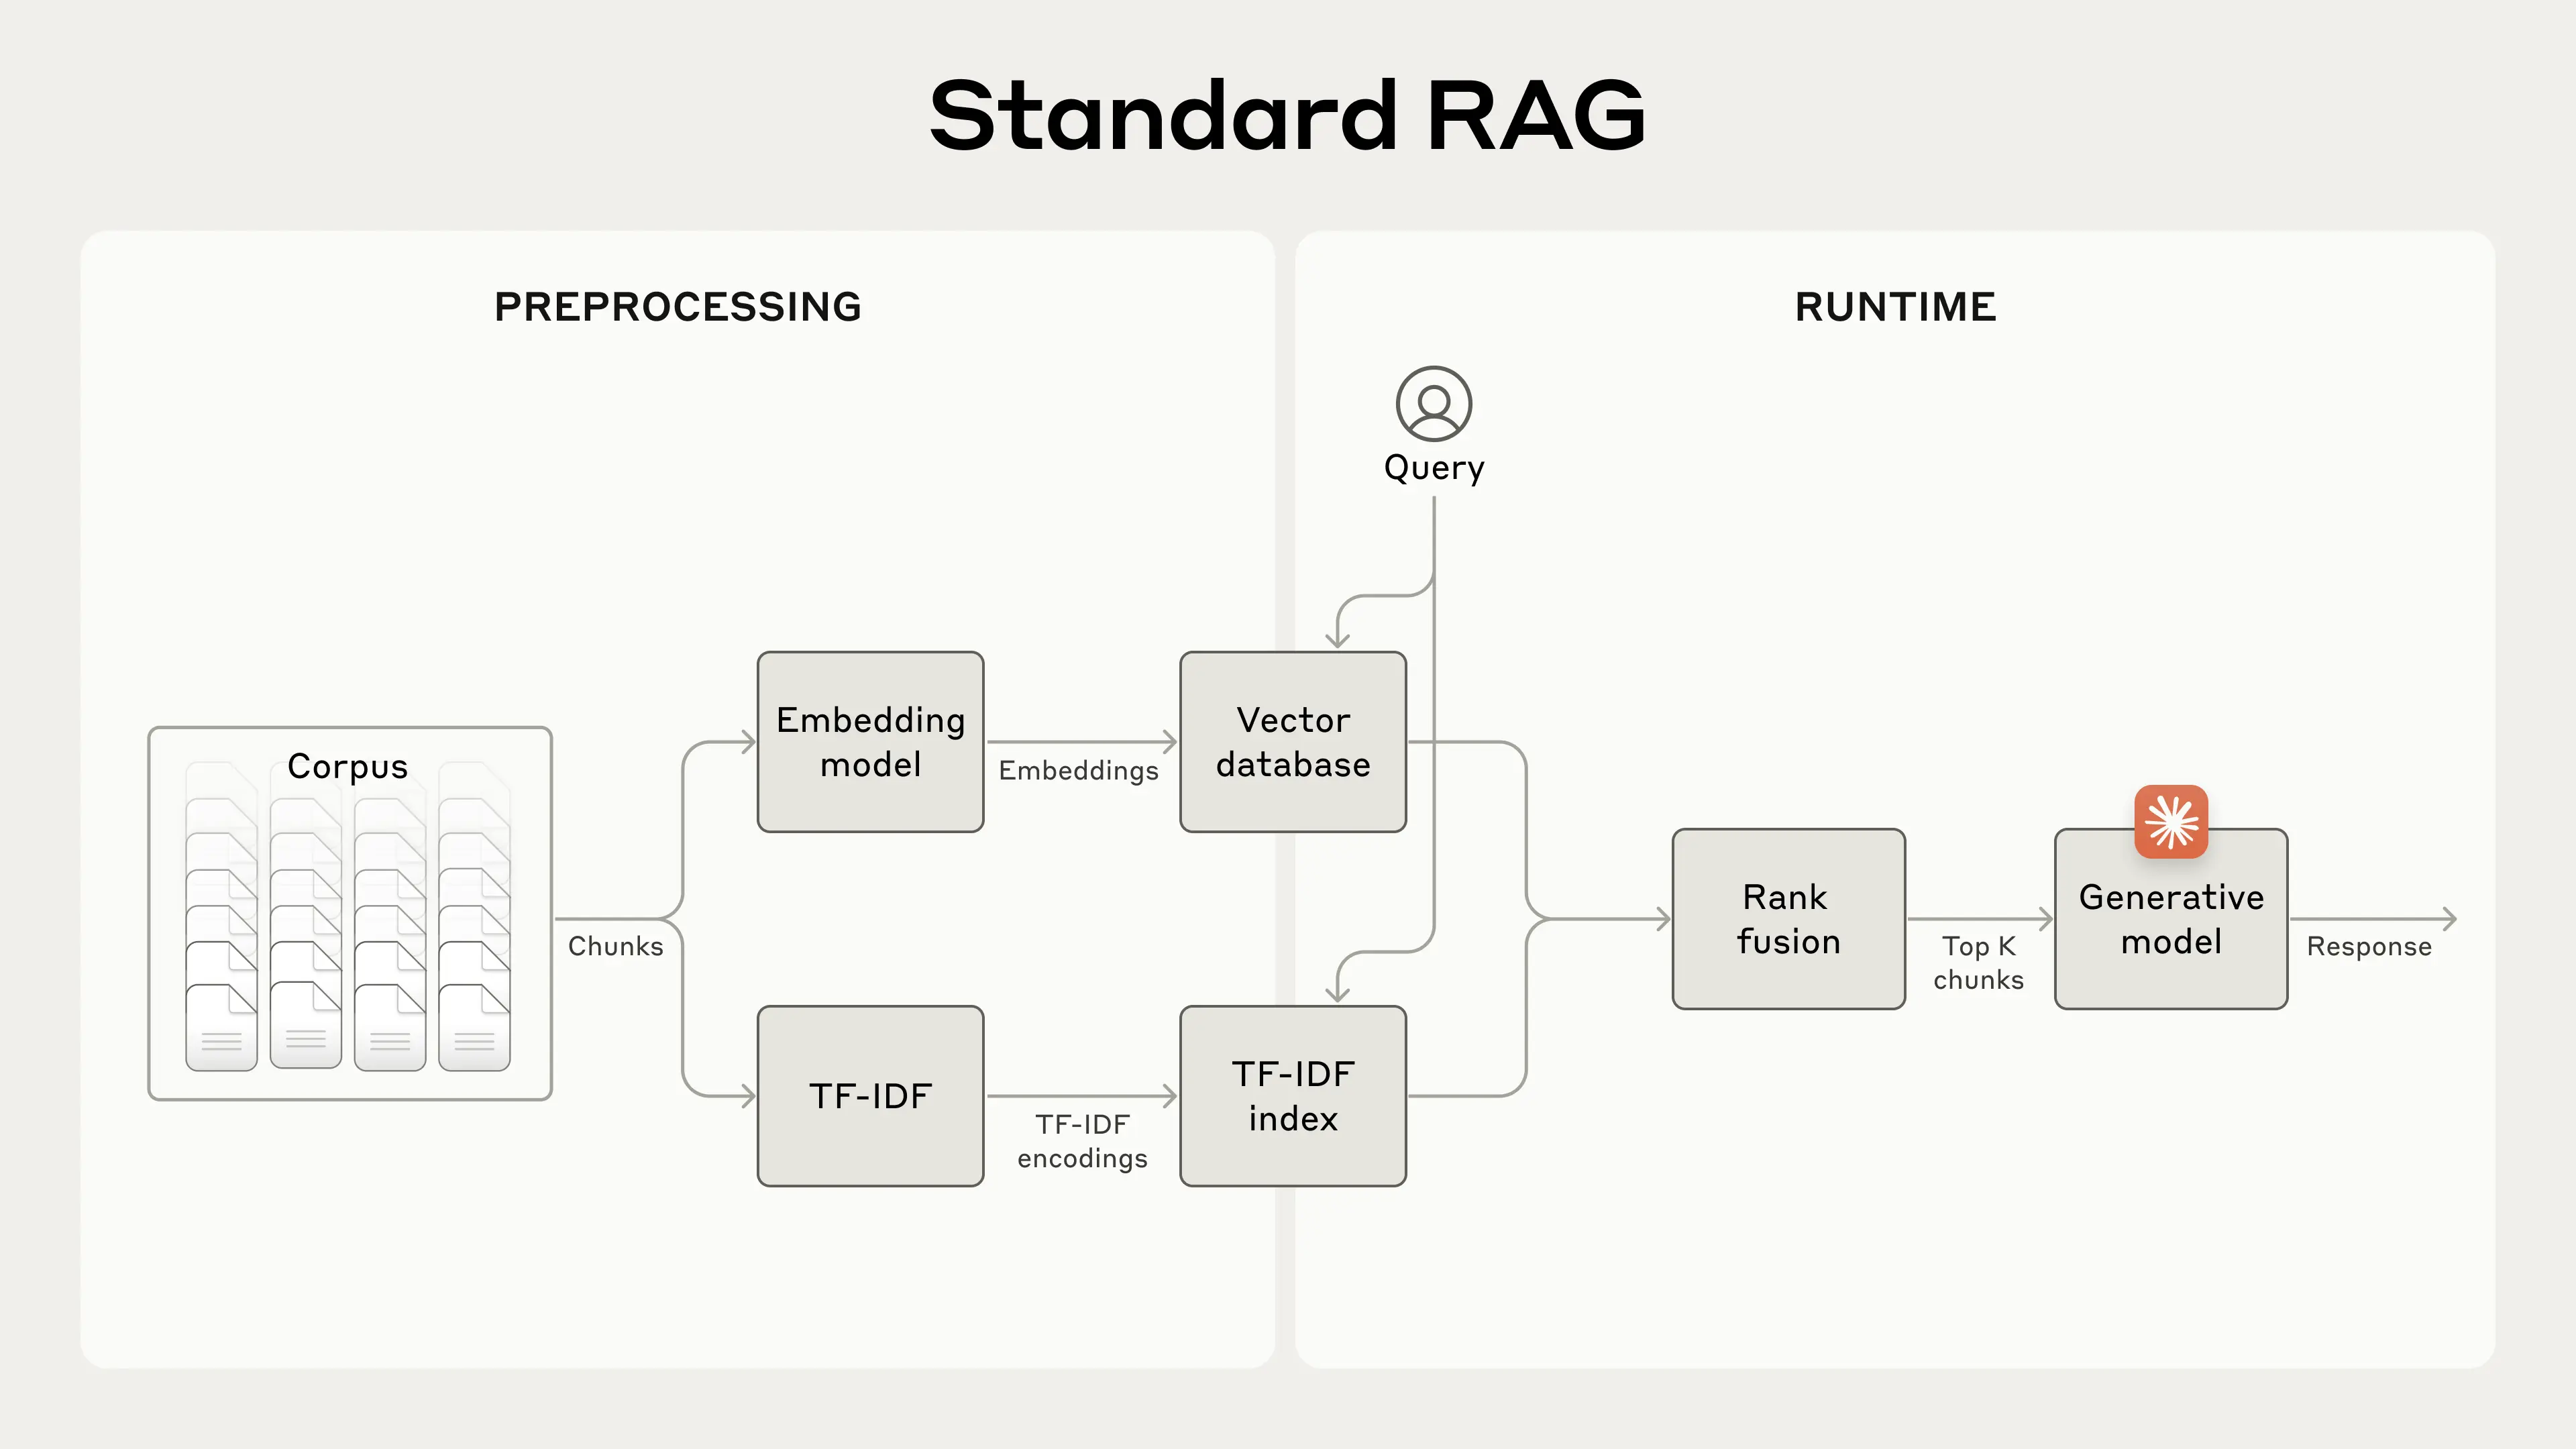

### The Process of TF-IDF in RAG:


- **Is a Keyword-based Retrieval System.**

- We have Our Chunks.

**- The Processing Step to Build the TF-IDF index :**

   1. We First build a Vocabulary (With Lemmatization and Stemming preprocessing) set from all the Chunks.

   2. For each Chunk we calculate the TF-IDF representation :

      21. We pass trough all the words in the chunk and we calculate their TF-IDF score.
      22. We append each TF-IDF score to a list.
      23. The result is a Sparse Vector that represent the Chunk with the same length as the Vocabulary, if a word is not in the Chunk but in the Vocabulary it's score is 0.

   3. Finaly we store all The TF-IDF Chunk-Representations in a TF-IDF index.

**- The Runtime Step:**

   1. We have Now a User Query, we process it the same like a Chunk, the result is Vector with the same length of the Vocabulary.

   2. Cosine similarity between the User Query and the Chunks is calculated.

   3. We select the Chunks with the highest score.

### TF-IDF Method :

- This technique is Compose of two terms : TF and IDF

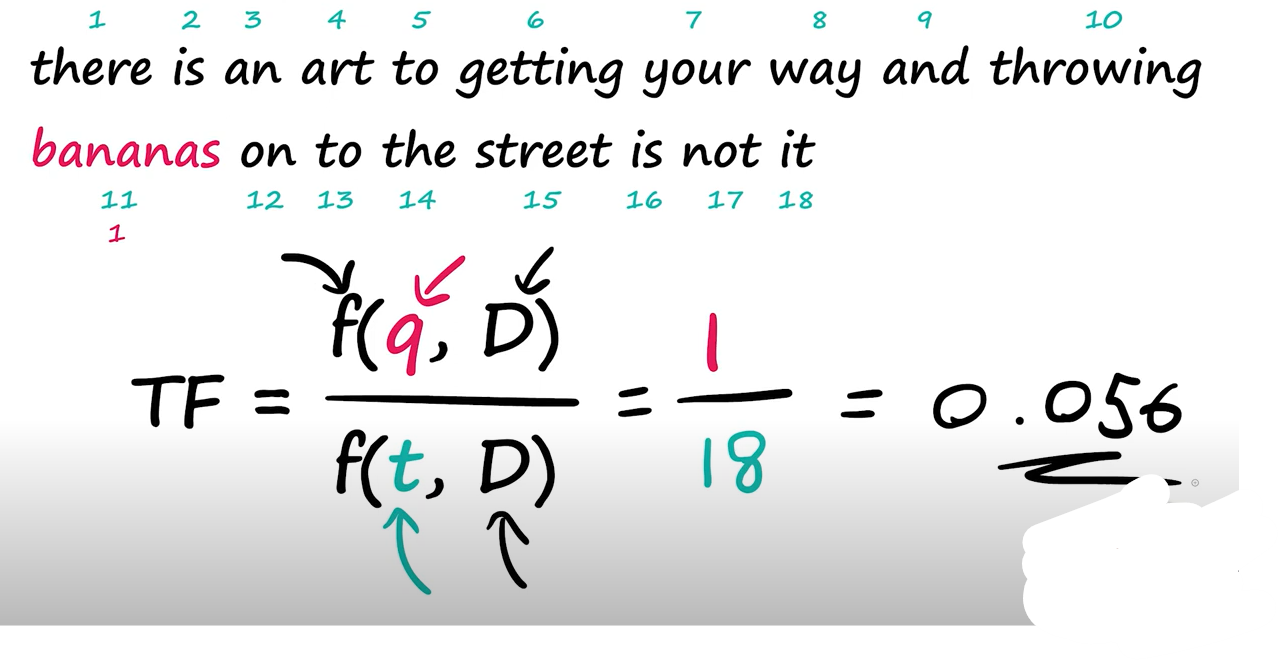

- **TF(q,D)** : Term Frequency of Query q in Document D.
- **TF** = (f(q,D) / f(t,D))
- **f(q,D)** : Is the frequency of the Query q in the document D.
- **f(t,D) or L** : The length of the document.
- More TF is heigh more the q is Popular in the document.

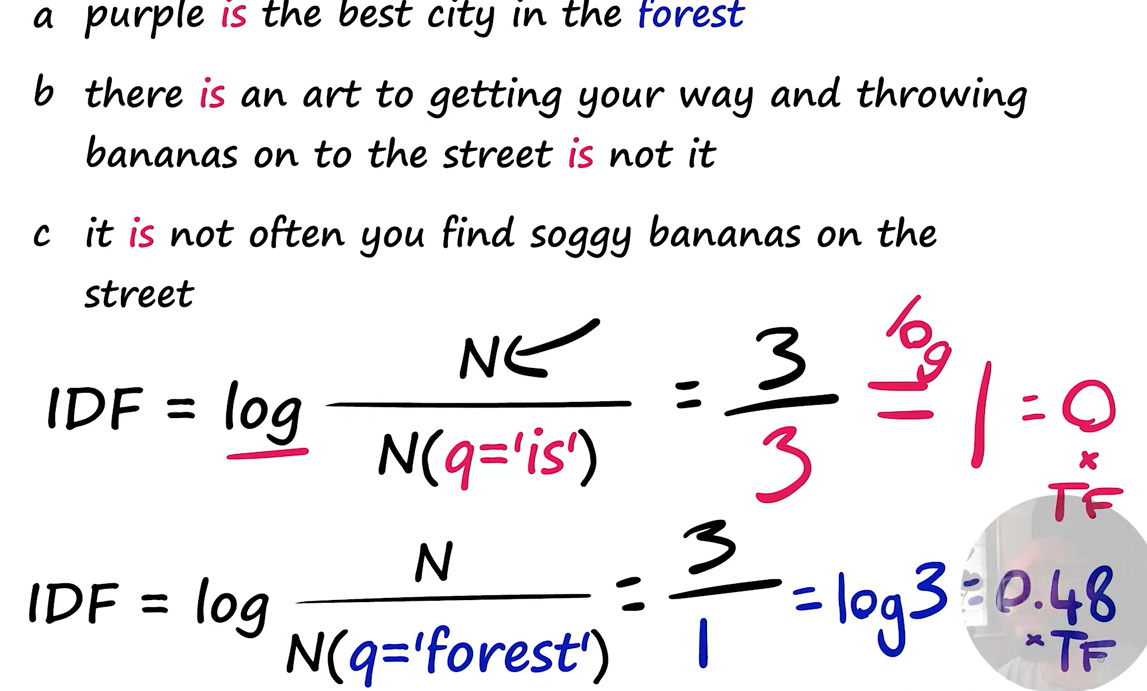

- **IDF(q)** : Inverse Document Frequency of Query q.
- **IDF** = log (N / N(q))
- **N** : The number of documents in the collection.
- **N(q)** :  The number of documents that contains the query q.
- IDF is heigh more the q is Rare in the collection of documents.

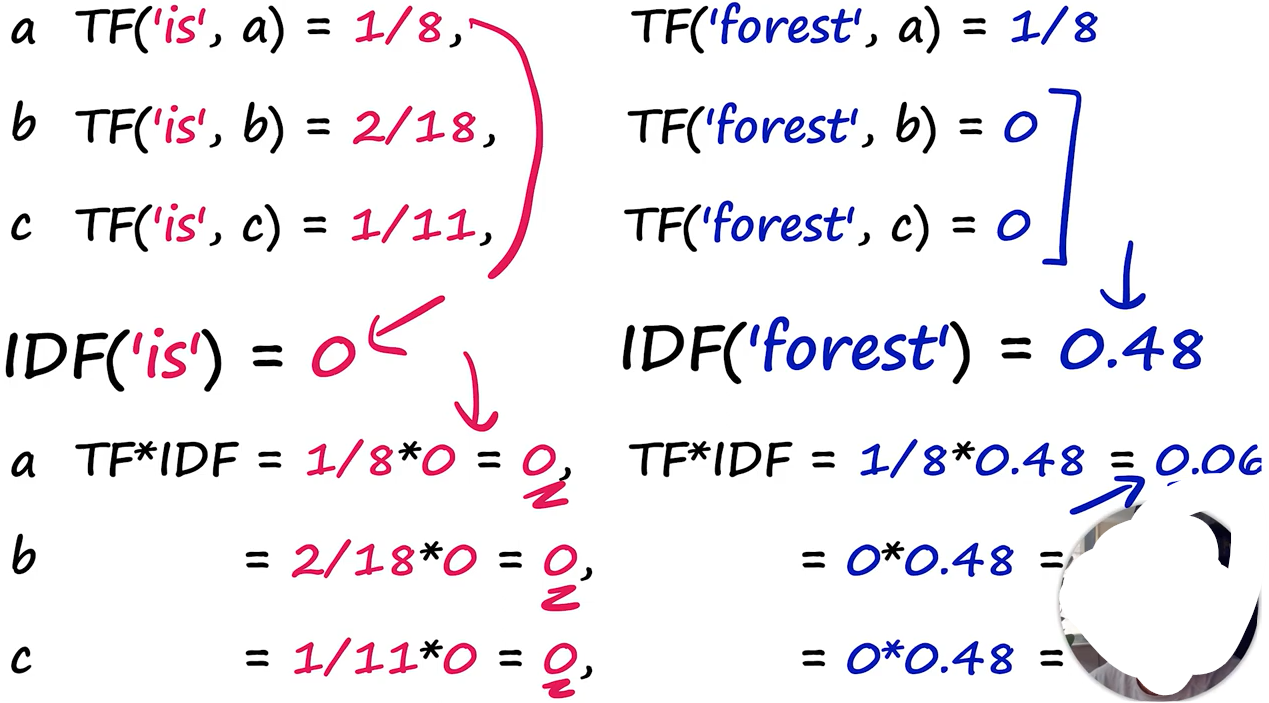

- Example here for `is` is a commun term so the TF-IDF is 0, However for `forest` the TF-IDF for Document a is 0.06

#### TF-IDF representation :

- Is a NLP technique that use TF-IDF algorithm to provide numerical representation of words a document.
- Is a **Sparse technique** ,We call it sparse because the Vector that encode a document contain a lot of zeros.
1. We first construct a Vocabulary set from all the documents.
2. In a Loop we calculate the TF-IDF score for each word in the vocabulary for a Document.
3. We append each TF-IDF score to a list.
4. The result is a Sparse Vector that represent the Document.

#### Mesure Documents Relevance :

- More TF(q,D)*IDF(q) is heigh more the document D is Relevent to the query q.


### BM25 Method :

- It's an enhanced version of TF-IDF algorithm.
- **BM** : Best Matching.
- **25** : is the version of this algorithm.

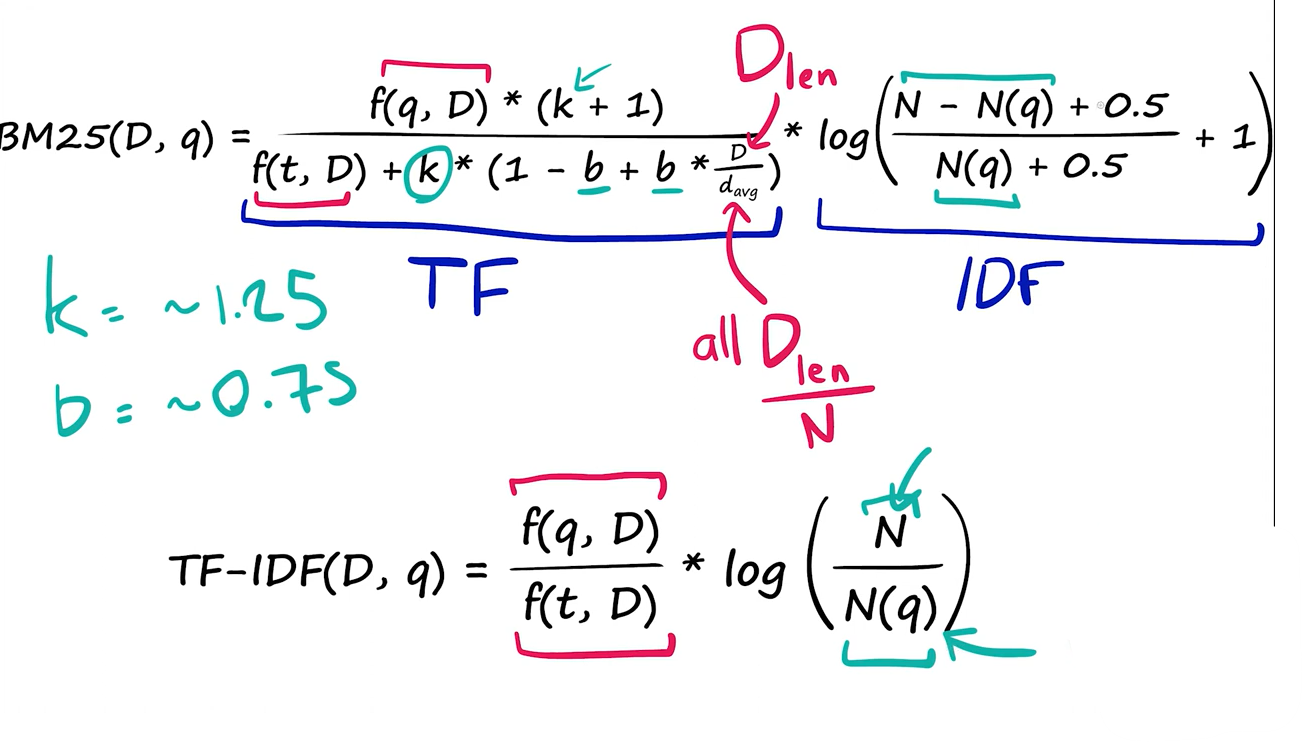

#### BM25 representation :


- Is a **Sparse technique** ,We call it sparse because the Vector that encode a document contain a lot of zeros.
1. We first construct a Vocabulary set from all the documents.
2. In a Loop we calculate the BM25 score for each word in the vocabulary for a Document.
3. We append each BM25 score to a list.
4. The result is a Sparse Vector that represent the Document.

### Standard RAG in Practise :

#### Creating Vector Database

In [1]:
from Utilitis import Load_Files,Save_to_chroma,Chunk

ModuleNotFoundError: No module named 'langchain_community'

In [ ]:
Files_Path = "./data1"
CHROMA_PATH = "./data1/Chroma"
Documents = Load_Files(Files_Path)
Chunks = Chunk(Documents)
Save_to_chroma(Chunks,CHROMA_PATH)

#### Embedding-Based Retrieval :